In [1]:
# Install Kaggle API
!pip install kaggle

# Move the uploaded kaggle.json to the correct directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions


In [2]:
# Download dataset from Kaggle
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

# Unzip the dataset
!unzip -o lgg-mri-segmentation.zip -d lgg-mri-segmentation


Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1

In [3]:
!pip install segmentation-models-pytorch torch torchvision albumentations numpy


In [4]:
import os
import glob
import pandas as pd
import torch
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


# ✅ Function to extract patient ID and match images with masks
def get_file_row(path):
    """
    Extracts the patient ID and identifies the corresponding MRI scan and segmentation mask.
    """
    path_no_ext, ext = os.path.splitext(path)
    filename = os.path.basename(path)
    patient_id = "_".join(filename.split("_")[:3])  # Extracts Patient ID
    return patient_id, path, f'{path_no_ext}_mask{ext}'


# ✅ Define dataset path
dataset_path = "lgg-mri-segmentation/kaggle_3m"

# ✅ Get all MRI image paths
file_paths = glob.glob(f"{dataset_path}/**/*.tif", recursive=True)

# ✅ Create a DataFrame with Patient ID, MRI scan, and corresponding mask
filenames_df = pd.DataFrame([get_file_row(filename) for filename in file_paths],
                            columns=["Patient", "Image Filename", "Mask Filename"])

# ✅ Remove duplicates and sort by Patient ID
filenames_df = filenames_df.drop_duplicates().sort_values(by="Patient")

# ✅ Ensure that all masks exist
valid_entries = filenames_df[filenames_df["Mask Filename"].apply(os.path.exists)].copy()

# ✅ Remove patients where the mask is missing
invalid_patients = set(filenames_df["Patient"]) - set(valid_entries["Patient"])
print(f"Removing {len(invalid_patients)} patients due to missing masks.")

# ✅ Extract sorted MRI and mask file paths
filtered_mri_files = valid_entries["Image Filename"].tolist()
filtered_mask_files = valid_entries["Mask Filename"].tolist()

# ✅ Split the dataset into Training (80%), Validation (10%), and Test (10%)
train_mri, temp_mri, train_mask, temp_mask = train_test_split(
    filtered_mri_files, filtered_mask_files, test_size=0.2, random_state=42
)

val_mri, test_mri, val_mask, test_mask = train_test_split(
    temp_mri, temp_mask, test_size=0.5, random_state=42
)

print(f"Training set size: {len(train_mri)}")
print(f"Validation set size: {len(val_mri)}")
print(f"Test set size: {len(test_mri)}")


Removing 0 patients due to missing masks.
Training set size: 3143
Validation set size: 393
Test set size: 393


In [5]:
import torch
from torchvision import transforms

# Define preprocessing function
def preprocess_image(image_path, mask=False):
    """Load, resize, normalize, and convert MRI scans & masks to tensors."""
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    image = image.resize((128, 128))  # Resize to match model input

    image_array = np.array(image) / 255.0  # Normalize pixel values to 0-1

    if mask:  # Masks are binary (0 or 1)
        image_array = (image_array > 0.5).astype(np.float32)  # Convert to binary mask

    image_tensor = torch.tensor(image_array, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
    return image_tensor


In [6]:
class BrainMRIDataset(Dataset):
    """Custom PyTorch Dataset for MRI Segmentation with Patient ID tracking."""
    def __init__(self, image_paths, mask_paths, patient_ids):
        self.image_paths = []
        self.mask_paths = []
        self.patient_ids = []

        for img, mask, pid in zip(image_paths, mask_paths, patient_ids):
            mask_image = Image.open(mask).convert("L")  # Load mask as grayscale
            mask_array = np.array(mask_image)  # Convert to NumPy array

            if np.any(mask_array > 0):  # ✅ Keep only masks that contain tumors
                self.image_paths.append(img)
                self.mask_paths.append(mask)
                self.patient_ids.append(pid)  # ✅ Store corresponding Patient ID

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        mri_image = preprocess_image(self.image_paths[idx])  # Load MRI scan
        mask_image = preprocess_image(self.mask_paths[idx], mask=True)  # Load segmentation mask
        patient_id = self.patient_ids[idx]  # Retrieve patient ID
        return mri_image, mask_image, patient_id


In [7]:
# Extract Patient IDs
train_ids = ["_".join(os.path.basename(fname).split("_")[:3]) for fname in train_mri]
val_ids = ["_".join(os.path.basename(fname).split("_")[:3]) for fname in val_mri]
test_ids = ["_".join(os.path.basename(fname).split("_")[:3]) for fname in test_mri]

# ✅ Create datasets with corresponding Patient IDs
train_dataset = BrainMRIDataset(train_mri, train_mask, train_ids)
val_dataset = BrainMRIDataset(val_mri, val_mask, val_ids)
test_dataset = BrainMRIDataset(test_mri, test_mask, test_ids)

# ✅ Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Before squeeze - MRI batch shape: torch.Size([32, 1, 128, 128])
Before squeeze - Mask batch shape: torch.Size([32, 1, 128, 128])
After squeeze - MRI batch shape: torch.Size([32, 128, 128])
After squeeze - Mask batch shape: torch.Size([32, 128, 128])


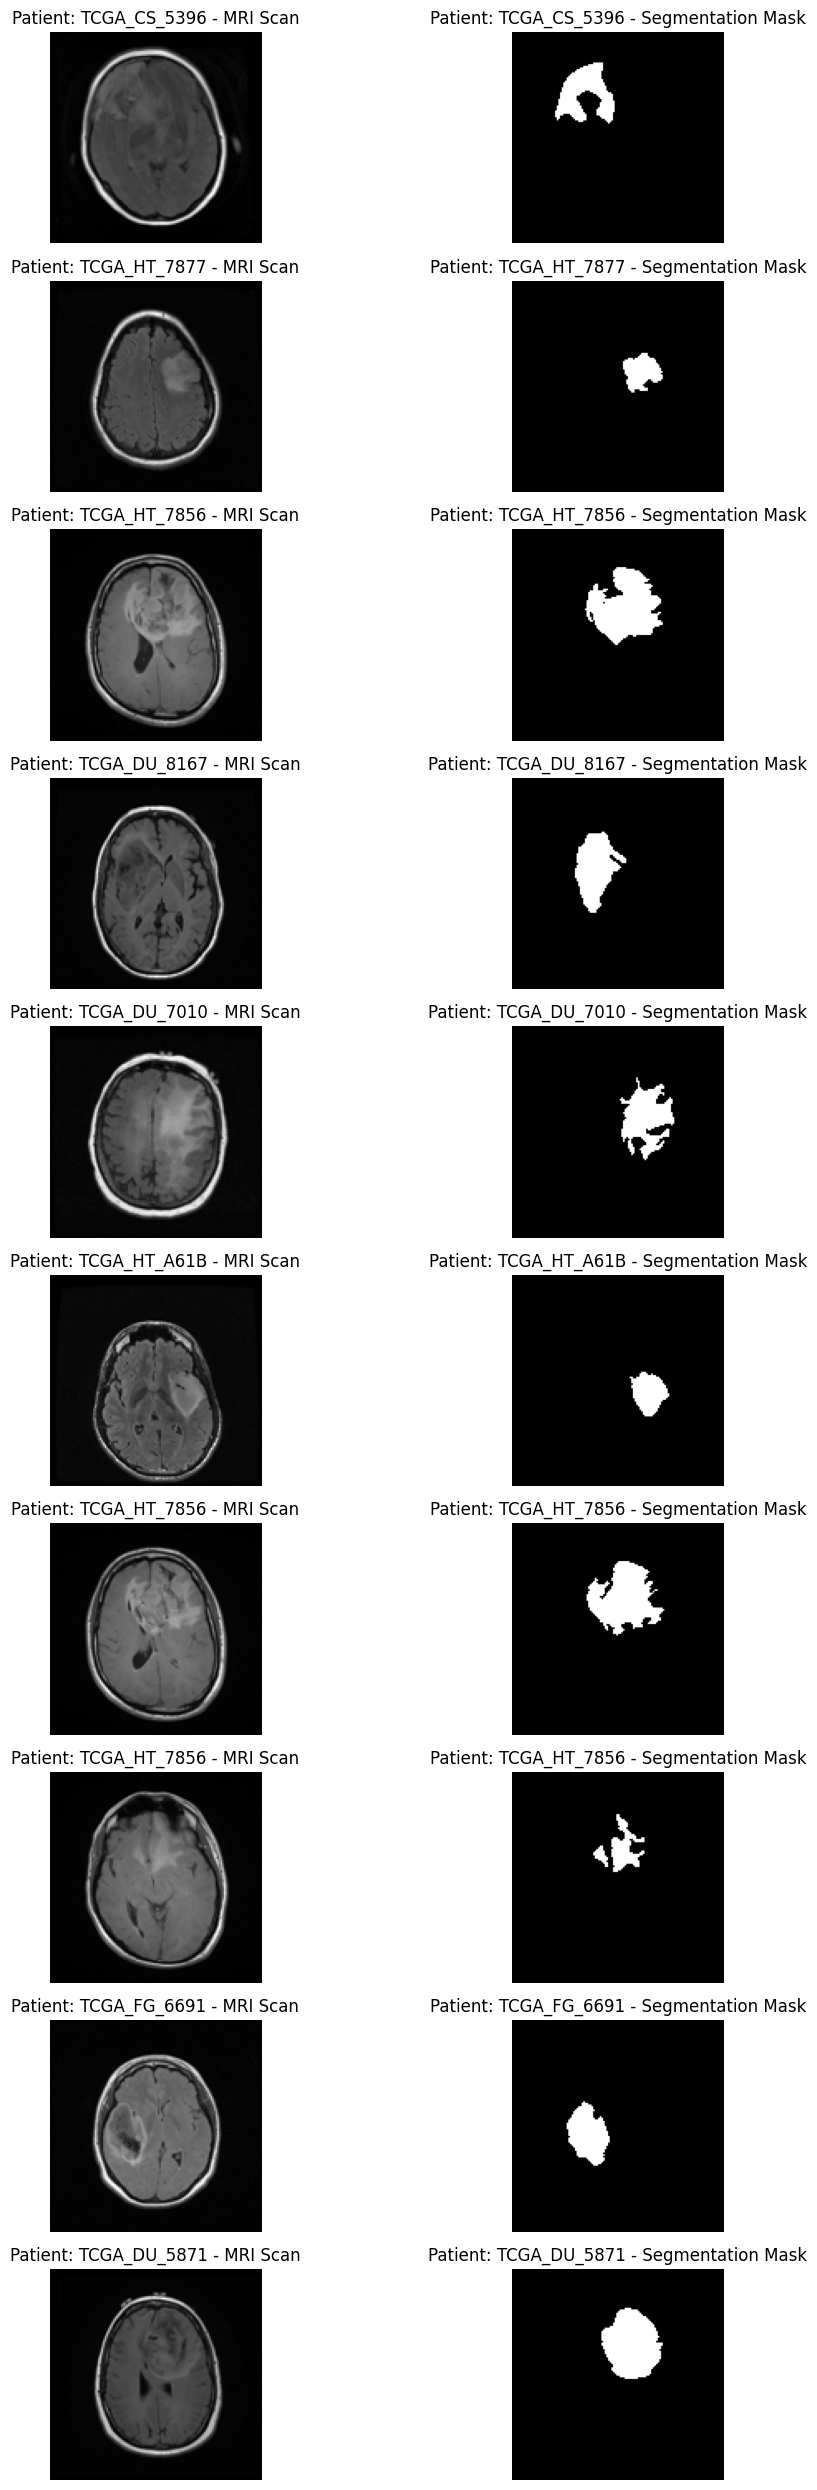

In [8]:
import matplotlib.pyplot as plt

# ✅ Retrieve a batch of MRI scans, masks, and patient IDs
mri_batch, mask_batch, patient_ids = next(iter(train_dataloader))

# Ensure we have at least 10 images in the batch
num_samples = min(10, mri_batch.shape[0])

# ✅ Extract correct patient IDs from batch
batch_patient_ids = patient_ids[:num_samples]  # Ensure IDs match batch

# Print shape before and after squeeze for debugging
print(f"Before squeeze - MRI batch shape: {mri_batch.shape}")
print(f"Before squeeze - Mask batch shape: {mask_batch.shape}")

# Apply squeeze
mri_squeezed = mri_batch.squeeze()
mask_squeezed = mask_batch.squeeze()

print(f"After squeeze - MRI batch shape: {mri_squeezed.shape}")
print(f"After squeeze - Mask batch shape: {mask_squeezed.shape}")

# ✅ Create subplots: 10 rows, 2 columns (MRI & Mask with correct IDs)
fig, axes = plt.subplots(num_samples, 2, figsize=(12, num_samples * 2.5))

for i in range(num_samples):
    # Extract MRI and mask after squeeze
    mri_img = mri_squeezed[i].numpy()
    mask_img = mask_squeezed[i].numpy()
    patient_id = batch_patient_ids[i]  # ✅ Correctly matched Patient ID

    # Display MRI Image
    axes[i, 0].imshow(mri_img, cmap="gray")
    axes[i, 0].set_title(f"Patient: {patient_id} - MRI Scan")
    axes[i, 0].axis("off")

    # Display Segmentation Mask
    axes[i, 1].imshow(mask_img, cmap="gray")
    axes[i, 1].set_title(f"Patient: {patient_id} - Segmentation Mask")
    axes[i, 1].axis("off")

# Adjust layout for better visibility
plt.tight_layout()
plt.show()


In [9]:
import segmentation_models_pytorch as smp

# ✅ Move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Define U-Net++ Model
unetplusplus_model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet", # Use pre-trained weights
    in_channels=1, # Grayscale MRI
    classes=1, # Binary segmentation (tumor vs. background)
)

# ✅ Define DeepLabV3+ Model
deeplab_model = smp.DeepLabV3Plus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unetplusplus_model.to(device)
deeplab_model.to(device)

# Print model summary
print("U-Net++ Model Summary:")
print(unetplusplus_model)
print("\nDeepLabV3+ Model Summary:")
print(deeplab_model)


U-Net++ Model Summary:
UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, m

In [27]:
import time
import torch.nn as nn
import torch.optim as optim
from torch.amp import autocast, GradScaler

scaler = GradScaler("cuda")  # ✅ Use correct AMP version

# ✅ Define loss function
criterion = nn.BCEWithLogitsLoss()

# ✅ Define optimizers separately for each model
optimizer_unet = optim.Adam(unetplusplus_model.parameters(), lr=0.0001)
optimizer_deeplab = optim.Adam(deeplab_model.parameters(), lr=0.0001)

# ✅ Define GradScaler for Mixed Precision Training
scaler = GradScaler("cuda")

# ✅ Training function that works for any model
def train_model(model, optimizer, train_loader, val_loader, num_epochs=5, model_name="Model"):
    model.train()

    for epoch in range(num_epochs):
        start_time = time.time()
        running_loss = 0.0
        batch_count = len(train_loader)

        print(f"\n🚀 Training {model_name} - Epoch {epoch+1}/{num_epochs} -------------------")

        for batch_idx, (images, masks, _) in enumerate(train_loader):  # ✅ Get Patient ID but do not use
            images, masks = images.to(device), masks.to(device)

            with autocast("cuda"):  # ✅ Use AMP for faster training
                outputs = model(images)
                loss = criterion(outputs, masks)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"  🔄 {model_name} - Batch {batch_idx+1}/{batch_count} - Loss: {loss.item():.4f}")

        epoch_time = time.time() - start_time

        # ✅ Validation Phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks, _ in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, masks).item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"✅ {model_name} - Epoch {epoch+1} Finished - Train Loss: {running_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Time: {epoch_time:.2f} sec")
        model.train()  # ✅ Switch back to training mode


# ✅ Train U-Net++
train_model(unetplusplus_model, optimizer_unet, train_dataloader, val_dataloader, num_epochs=150, model_name="U-Net++")

# ✅ Train DeepLabV3+
train_model(deeplab_model, optimizer_deeplab, train_dataloader, val_dataloader, num_epochs=300, model_name="DeepLabV3+")



🚀 Training U-Net++ - Epoch 1/150 -------------------
  🔄 U-Net++ - Batch 10/35 - Loss: 0.1144
  🔄 U-Net++ - Batch 20/35 - Loss: 0.1094
  🔄 U-Net++ - Batch 30/35 - Loss: 0.1037
✅ U-Net++ - Epoch 1 Finished - Train Loss: 3.8875, Val Loss: 0.1063, Time: 7.40 sec

🚀 Training U-Net++ - Epoch 2/150 -------------------
  🔄 U-Net++ - Batch 10/35 - Loss: 0.0989
  🔄 U-Net++ - Batch 20/35 - Loss: 0.0949
  🔄 U-Net++ - Batch 30/35 - Loss: 0.0919
✅ U-Net++ - Epoch 2 Finished - Train Loss: 3.3511, Val Loss: 0.0925, Time: 6.97 sec

🚀 Training U-Net++ - Epoch 3/150 -------------------
  🔄 U-Net++ - Batch 10/35 - Loss: 0.0826
  🔄 U-Net++ - Batch 20/35 - Loss: 0.0818
  🔄 U-Net++ - Batch 30/35 - Loss: 0.0789
✅ U-Net++ - Epoch 3 Finished - Train Loss: 2.8996, Val Loss: 0.0820, Time: 7.40 sec

🚀 Training U-Net++ - Epoch 4/150 -------------------
  🔄 U-Net++ - Batch 10/35 - Loss: 0.0753
  🔄 U-Net++ - Batch 20/35 - Loss: 0.0719
  🔄 U-Net++ - Batch 30/35 - Loss: 0.0707
✅ U-Net++ - Epoch 4 Finished - Train Los

In [28]:
# Save the trained models
torch.save(unetplusplus_model.state_dict(), "unetplusplus_mri_segmentation.pth")
torch.save(deeplab_model.state_dict(), "deeplabv3plus_mri_segmentation.pth")
print("✅ Models saved successfully!")



✅ Models saved successfully!


Test batch type: <class 'list'>
Test batch length: 3
First batch element type: <class 'torch.Tensor'>


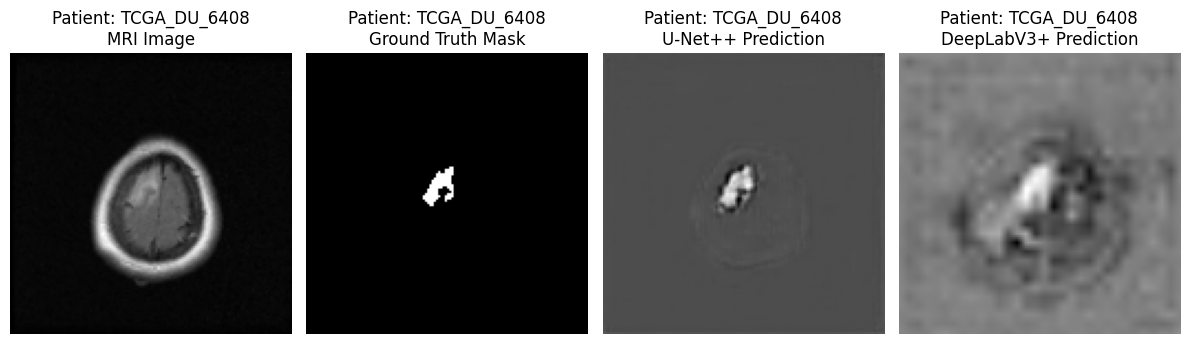

In [29]:
import torch
import matplotlib.pyplot as plt

# ✅ Load trained models safely
unetplusplus_model.load_state_dict(torch.load("unetplusplus_mri_segmentation.pth", weights_only=True))
unetplusplus_model.to(device)
unetplusplus_model.eval()

deeplab_model.load_state_dict(torch.load("deeplabv3plus_mri_segmentation.pth", weights_only=True))
deeplab_model.to(device)
deeplab_model.eval()

# ✅ Fetch a batch of test images
test_batch = next(iter(test_dataloader))

# ✅ Debug: Print type and structure of test batch
print(f"Test batch type: {type(test_batch)}")  # Expecting <class 'list'>
print(f"Test batch length: {len(test_batch)}")  # Expecting 3 (Images, Masks, Patient IDs)
print(f"First batch element type: {type(test_batch[0])}")  # Expecting tensor

# ✅ Fix: Unpack based on correct list format
if isinstance(test_batch, list) and len(test_batch) == 3:
    test_images = test_batch[0]  # ✅ MRI images
    test_masks = test_batch[1]  # ✅ Segmentation masks
    test_patient_ids = test_batch[2]  # ✅ Patient IDs
else:
    raise ValueError(f"❌ Unexpected test batch format! Expected list of (images, masks, patient_ids) but got {test_batch}")

# ✅ Select one test image & ensure correct shape
test_image = test_images[0].unsqueeze(0).to(device)  # Ensure correct batch dimension
test_mask = test_masks[0].cpu().squeeze().numpy()  # Ground truth mask
test_patient_id = test_patient_ids[0]  # ✅ Get corresponding Patient ID

# ✅ Get model predictions
with torch.no_grad():
    unetplusplus_pred = unetplusplus_model(test_image)
    deeplab_pred = deeplab_model(test_image)

# ✅ Ensure predictions are correctly shaped
unetplusplus_pred_np = unetplusplus_pred.cpu().squeeze().numpy()
deeplab_pred_np = deeplab_pred.cpu().squeeze().numpy()

# ✅ Convert test image to NumPy for visualization
test_image_np = test_image.cpu().squeeze().numpy()

# ✅ Display MRI, Ground Truth, U-Net++ Prediction, and DeepLabV3+ Prediction
plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.title(f"Patient: {test_patient_id}\nMRI Image")  # ✅ Add Patient ID
plt.imshow(test_image_np, cmap="gray")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.title(f"Patient: {test_patient_id}\nGround Truth Mask")
plt.imshow(test_mask, cmap="gray")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.title(f"Patient: {test_patient_id}\nU-Net++ Prediction")
plt.imshow(unetplusplus_pred_np, cmap="gray")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.title(f"Patient: {test_patient_id}\nDeepLabV3+ Prediction")
plt.imshow(deeplab_pred_np, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


In [30]:
# Load trained U-Net++
unetplusplus_model.load_state_dict(torch.load("unetplusplus_mri_segmentation.pth"))
unetplusplus_model.to(device)
unetplusplus_model.eval()

# Load trained DeepLabV3+
deeplab_model.load_state_dict(torch.load("deeplabv3plus_mri_segmentation.pth"))
deeplab_model.to(device)
deeplab_model.eval()

print("✅ Models loaded successfully!")



<ipython-input-30-213a96ba0822>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unetplusplus_model.load_state_dict(torch.load("unetplusplus_mri_segmentation.pth"))
<ipython

✅ Models loaded successfully!


In [31]:
from sklearn.metrics import accuracy_score, jaccard_score

def evaluate_model(model, dataloader, model_name="Model"):
    """Evaluates a segmentation model using Accuracy and IoU."""
    model.eval()
    total_accuracy = 0.0
    total_iou = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            if len(batch) == 3:  # ✅ Fix: Handle extra Patient ID
                images, masks, _ = batch  # Ignore patient IDs
            else:
                images, masks = batch  # Standard case (no patient IDs)

            images, masks = images.to(device), masks.to(device)

            # ✅ Ensure images are 4D (Batch, 1, 128, 128)
            if images.dim() == 5:
                images = images.squeeze(1)  # Remove extra channel dimension
                masks = masks.squeeze(1)

            # Get model predictions
            predictions = model(images)
            predictions = (predictions > 0.5).float()  # Convert logits to binary mask

            # Flatten tensors for accuracy computation
            true_mask = masks.cpu().numpy().flatten()
            pred_mask = predictions.cpu().numpy().flatten()

            # Compute Accuracy and IoU
            batch_accuracy = accuracy_score(true_mask, pred_mask)
            batch_iou = jaccard_score(true_mask, pred_mask, average='binary')

            total_accuracy += batch_accuracy
            total_iou += batch_iou
            num_samples += 1

    # Compute Average Accuracy and IoU
    avg_accuracy = total_accuracy / num_samples
    avg_iou = total_iou / num_samples

    print(f"\n Evaluation Results for {model_name}:")
    print(f" Accuracy: {avg_accuracy:.4f}")
    print(f" IoU Score: {avg_iou:.4f}")

    return avg_accuracy, avg_iou

print("\n Final Evaluation on Test Set")

# ✅ Evaluate U-Net++ on Test Set
accuracy_unet_test, iou_unet_test = evaluate_model(unetplusplus_model, test_dataloader, model_name="U-Net++ (Test Set)")

# ✅ Evaluate DeepLabV3+ on Test Set
accuracy_deeplab_test, iou_deeplab_test = evaluate_model(deeplab_model, test_dataloader, model_name="DeepLabV3+ (Test Set)")


 Final Evaluation on Test Set

 Evaluation Results for U-Net++ (Test Set):
 Accuracy: 0.9932
 IoU Score: 0.7961

 Evaluation Results for DeepLabV3+ (Test Set):
 Accuracy: 0.9924
 IoU Score: 0.7721
